In [5]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = '792003cde0750f1452faa5cb5fe7c57da849e1119983f608e9a359d49cdb396391d6af09eedfb46af0a043a01103ed64da66835d1a318c0013d64ab3ebc1fe61'
qk.IBMQ.save_account(token=token)
qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')
backend = provider.get_backend("ibmq_toronto")


configrc.store_credentials:WARNING:2022-06-26 16:34:49,526: Credentials already present. Set overwrite=True to overwrite.


IBMQAccountError: 'An IBM Quantum Experience account is already in use for the session.'

In [ ]:
print(IBMQ.providers())

In [6]:
import pickle

def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    counter = 0
    temp = [] 
    for key in db:
        temp.append(key)
    print(counter)
    dbfile.close()
    return temp

data=loadData('FGRAFS_controls_N128.p')
temp = []
for i in data:
    for j in range(int(4)):
        temp.append(i)
print(len(temp), " " , len(data))

0
512   128


Job Status: job has successfully run
1 :  0.11121622441459623
Job Status: job has successfully run
[ 1.45783437e-09 -5.72942410e-11  2.40186713e-01  1.22505292e-10]


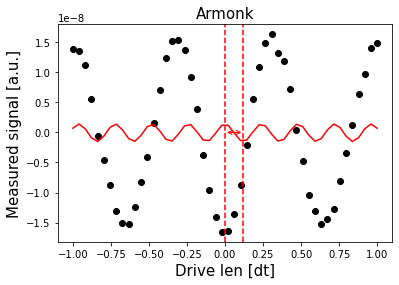

Time taken: 64.68108987808228


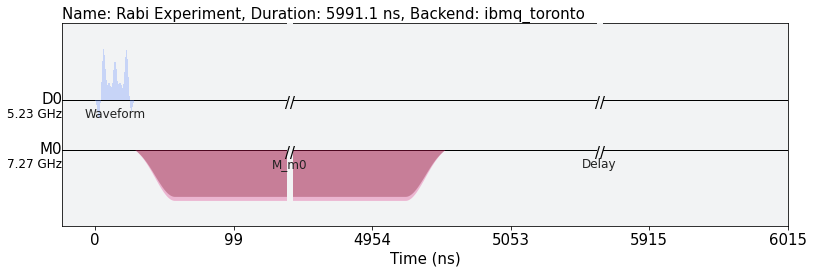

In [7]:
import time

# Generate circuits and run on simulator
t = time.time()
test= [x**2 for x in range(64)]
signal = Su22.Custom_Fgp('low_freq',data,backend)
#print(signal.input)
#print(signal.norm)
print('Time taken:', time.time() - t)
signal.draw()

In [22]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

drive_amps_2,rabi_values_2 = signal.Cali(50,signal.length)

Job Status: job has successfully run


[-1.52994070e-08 -5.84245192e-10  6.53815126e-01 -2.58655147e-02]


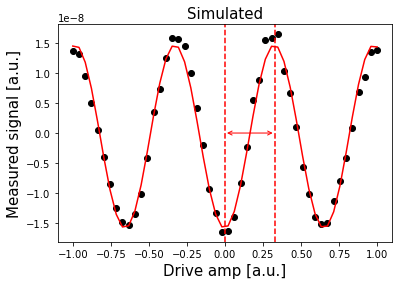

In [25]:
fit_params_2, y_fit_2 = fit_function(drive_amps_2,
                                 rabi_values_2, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [-8, 1, 0.5, 0])

plt.scatter(drive_amps_2, rabi_values_2, color='black')
plt.plot(drive_amps_2, y_fit_2, color='red')
print(fit_params_2)
drive_period_2 = fit_params_2[2] # get period of rabi oscillation

plt.axvline(0, color='red', linestyle='--')
plt.axvline(drive_period_2/2, color='red', linestyle='--')
plt.annotate("", xy=(0, 0), xytext=(drive_period_2/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period_2/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.title("Simulated", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [26]:
pi_amp_2 = abs(drive_period_2 / 2)
print(f"Pi Amplitude = {pi_amp_2}")
signal.pi_p = pi_amp_2

Pi Amplitude = 0.32690756303447066


In [27]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
import time

# Generate circuits and run on simulator
t = time.time()
circ = QuantumCircuit(1)
circ = signal.add_as_gate(circ,[0])
qst_bell = state_tomography_circuits(circ,[0])
qst_bell[2].draw('mpl')
job = qk.execute(qst_bell, backend=backend, shots=5000)
print('Time taken:', time.time() - t)

Time taken: 1.3259847164154053


In [29]:
q2 = QuantumRegister(1)
bell = QuantumCircuit(q2)
bell.x(q2[0])
print(bell)

job = qk.execute(bell, backend=Aer.get_backend('statevector_simulator'))
psi_bell = job.result().get_statevector(bell)
print(psi_bell)

t = time.time()
circ = QuantumCircuit(1)
circ = signal.add_as_gate(circ,[0])
#circ.x(0)
qst_bell = state_tomography_circuits(circ,[0])
qst_bell[2].draw('mpl')
print(qst_bell[2])
job = qk.execute(qst_bell, backend=backend, shots=5000)
print('Time taken:', time.time() - t)

tomo_bell = StateTomographyFitter(job.result(), qst_bell)
rho_bell = tomo_bell.fit()

     ┌───┐
q92: ┤ X ├
     └───┘
Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
      ┌──────────┐ ░ ┌─┐
   q: ┤ low_freq ├─░─┤M├
      └──────────┘ ░ └╥┘
c3: 1/════════════════╩═
                      0 
Time taken: 1.099297285079956


In [30]:
print(rho_bell)

[[0.6008+0.j     0.2958-0.3362j]
 [0.2958+0.3362j 0.3992+0.j    ]]


In [17]:
temp = np.tensordot(psi_bell,np.transpose(psi_bell),0)

In [18]:
print(temp)

[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


In [31]:
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity =', F_bell)

Fit Fidelity = 0.39920000000000005


In [124]:
storc = [8]
stnaoh = [0.1,0.15,0.2,0.25,0.3]
volume = 3
vol = 3
inc = 5
inc_vol = 0.5
tx = []
ty =[]
x_vals= []
y_vals = []
names=[]
for orc in storc:   
    for oh in stnaoh:
            temporc= orc
            tempoh=oh
            for i in range(inc+1):
                x_vals.append(tempoh)
                y_vals.append(temporc)
                temporc = temporc * (vol/(vol+inc_vol))
                tempoh = (tempoh*vol)/(vol+inc_vol)
                vol+=inc_vol
            vol = volume
            tx.append(x_vals)
            ty.append(y_vals)
            x_vals= []
            y_vals = []
            tempstr = str(orc) + "% orc + " + str(oh) + "N NaOH" 
            names.append(tempstr)
print(ty)

[[8, 6.857142857142857, 6.0, 5.333333333333333, 4.8, 4.363636363636363], [8, 6.857142857142857, 6.0, 5.333333333333333, 4.8, 4.363636363636363], [8, 6.857142857142857, 6.0, 5.333333333333333, 4.8, 4.363636363636363], [8, 6.857142857142857, 6.0, 5.333333333333333, 4.8, 4.363636363636363], [8, 6.857142857142857, 6.0, 5.333333333333333, 4.8, 4.363636363636363]]


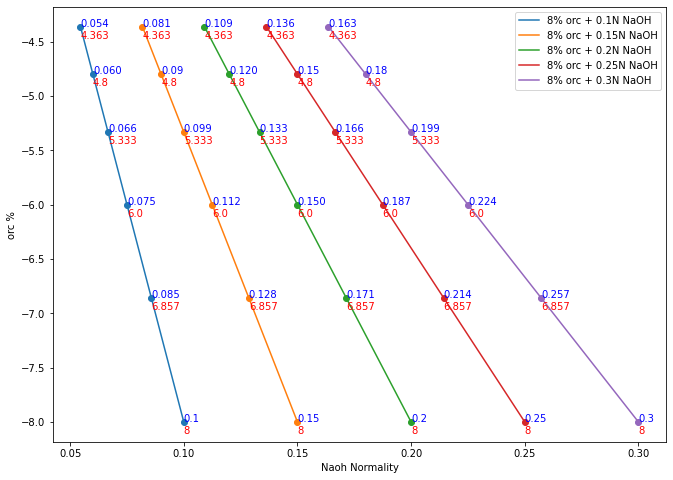

In [129]:
plt.figure(figsize=(11,8))
for i in range(len(tx)):
    plt.scatter(tx[i], -1*np.array(ty[i]))
    plt.plot(tx[i], -1*np.array(ty[i]),label=names[i])
plt.ylabel("orc %")
plt.xlabel("Naoh Normality")
plt.legend()
counter = 0
for j in tx:
    for i,label in enumerate(j):
        plt.annotate(str(label)[0:5], (tx[counter][i], -1*ty[counter][i]), color="blue")
        plt.annotate(str(ty[counter][i])[0:5], (tx[counter][i], -1*ty[counter][i]-0.11), color="red")
    counter+=1
plt.savefig("output.png")
plt.show()